# Luoman Bedding Analysis

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplstereonet
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
from functions import fisher_mean
from functions import make_di_block

import sys
sys.path.insert(0, '../pyStrat')
from pyStrat import *

/Users/yuempark/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Import Bedding Data

Note that these data are not the raw files exported from FieldMove - since the altitude data acquired from FieldMove is only relative, some post-processing has been done in QGIS to obtain absolute elevation values for each point based on a projection onto a DEM.

In [2]:
YP_plane = pd.read_csv('FieldMove/YP_plane.csv')
NSH_plane = pd.read_csv('FieldMove/NSH_plane.csv')

plane = pd.concat([YP_plane, NSH_plane], ignore_index=True)
plane.columns

Index(['X', 'Y', 'n27_e108_1', 'n28_e108_1', 'localityId', 'localityNa',
       'dataId', 'x', 'y', 'latitude', 'longitude', 'zone', 'altitude',
       'horiz_prec', 'vert_preci', 'planeType', 'dip', 'dipAzimuth', 'strike',
       'declinatio', 'unitId', 'timedate', 'notes'],
      dtype='object')

In [3]:
# pull out the columns that we want, and rename some of them
plane = pd.DataFrame({'latitude':plane['latitude'],
                      'longitude':plane['longitude'],
                      'altitude':plane['altitude'],
                      'horiz_precision':plane['horiz_prec'],
                      'planeType':plane['planeType'],
                      'dip':plane['dip'],
                      'dipAzimuth':plane['dipAzimuth'],
                      'strike':plane['strike'],
                      'declination':plane['declinatio'],
                      'unitId':plane['unitId'],
                      'timedate':plane['timedate'],
                      'notes':plane['notes'],
                      'elevation_1':plane['n27_e108_1'],
                      'elevation_2':plane['n28_e108_1']})

# extract the bedding data
bedding = plane[plane['planeType']=='Bedding'].copy()
bedding.reset_index(inplace=True, drop=True)

# merge the two elevation columns (taken from two separate DEM files)
for i in range(len(bedding.index)):
    if pd.notnull(bedding['elevation_1'][i]):
        bedding.loc[i, 'elevation'] = bedding['elevation_1'][i]
    else:
        bedding.loc[i, 'elevation'] = bedding['elevation_2'][i]

The Luoman data that we are interested in is bounded as follows:

In [4]:
Luoman_bedding = bedding[(bedding['longitude']>108.8) &
                         (bedding['longitude']<108.85) &
                         (bedding['latitude']>27.925) &
                         (bedding['latitude']<27.975)].copy()
Luoman_bedding.reset_index(drop=True,inplace=True)

/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


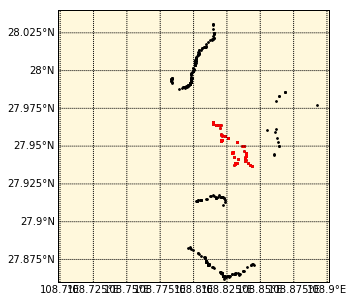

In [5]:
# set up the basemap
m = Basemap(width=20000,height=20000,
            resolution='c',projection='laea',\
            lat_0=27.95,lon_0=108.8)
fig = plt.figure(figsize=(5,5))
m.fillcontinents(color='cornsilk',lake_color='white',zorder=0)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(107,110,0.025),labels=[False,False,False,True])
m.drawparallels(np.arange(27,29,0.025),labels=[True,False,False,False])

# scatter the data
x, y = m(np.array(bedding['longitude']), np.array(bedding['latitude']))
m.scatter(x, y, 3, marker='o', color='k')

x, y = m(np.array(Luoman_bedding['longitude']), np.array(Luoman_bedding['latitude']))
m.scatter(x, y, 3, marker='o', color='r')

plt.show()

Furthermore, we want to exclude the data that was collected right next to a large fold, and that collected near smaller local folds (which are somewhat beyond the location of the measured sections anyway):

In [6]:
# get rid of measurements near the large fold
Luoman_bedding = Luoman_bedding[(Luoman_bedding['longitude']>108.825) |
                                (Luoman_bedding['longitude']<108.820) |
                                (Luoman_bedding['latitude']>27.955) |
                                (Luoman_bedding['latitude']<27.950)].copy()

# get rid of measurements near the smaller local folds
Luoman_bedding = Luoman_bedding[Luoman_bedding['latitude']<27.960].copy()

Luoman_bedding.reset_index(drop=True,inplace=True)

/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


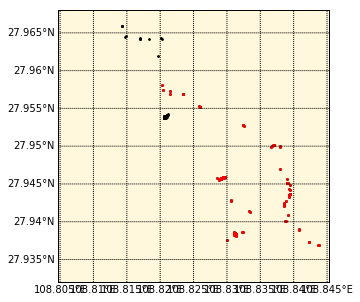

In [7]:
# set up the basemap
m = Basemap(width=4000,height=4000,
            resolution='c',projection='laea',\
            lat_0=27.95,lon_0=108.825)
fig = plt.figure(figsize=(5,5))
m.fillcontinents(color='cornsilk',lake_color='white',zorder=0)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(108,109,0.005),labels=[False,False,False,True])
m.drawparallels(np.arange(27,28,0.005),labels=[True,False,False,False])

# scatter the data
x, y = m(np.array(bedding['longitude']), np.array(bedding['latitude']))
m.scatter(x, y, 3, marker='o', color='k')

x, y = m(np.array(Luoman_bedding['longitude']), np.array(Luoman_bedding['latitude']))
m.scatter(x, y, 3, marker='o', color='r')

plt.show()

## Import Section Data

Note that these data are not the raw files exported from FieldMove - since the altitude data acquired from FieldMove is only relative, some post-processing has been done in QGIS to obtain absolute elevation values for each point based on a projection onto a DEM.

In [8]:
YP_notes = pd.read_csv('FieldMove/YP_notes.csv')

YP_notes.columns

Index(['X', 'Y', 'n27_e108_1', 'n28_e108_1', 'time', 'latitude', 'longitude',
       'localityNa', 'notes', 'image name', 'heading', 'planeType',
       'dipAzimuth', 'dip', 'lineationT', 'plungeAzim', 'plunge', 'unitId'],
      dtype='object')

In [9]:
# pull out the columns that we want, and rename some of them
YP_notes = pd.DataFrame({'latitude':YP_notes['latitude'],
                         'longitude':YP_notes['longitude'],
                         'timedate':YP_notes['time'],
                         'notes':YP_notes['notes'],
                         'elevation_1':YP_notes['n27_e108_1'],
                         'elevation_2':YP_notes['n28_e108_1']})

# get only the rows with the Luoman section information in them
drop_ind = np.array([])
for i in range(len(YP_notes.index)):
    if pd.notnull(YP_notes['notes'][i]):
        if 'Luoman 1' in YP_notes['notes'][i] or\
           'Luoman 2' in YP_notes['notes'][i] or\
           'Luoman 3' in YP_notes['notes'][i] or\
           'Luoman 4' in YP_notes['notes'][i] or\
           'Luoman 5' in YP_notes['notes'][i] or\
           'Luoman 6' in YP_notes['notes'][i] or\
           'Luoman 7' in YP_notes['notes'][i]:
            pass
        else:
            drop_ind = np.append(drop_ind, i)
    else:
        drop_ind = np.append(drop_ind, i)
        
Luoman_notes = YP_notes.drop(drop_ind)
Luoman_notes.reset_index(drop=True, inplace=True)

# merge the two elevation columns (taken from two separate DEM files)
for i in range(len(Luoman_notes.index)):
    if pd.notnull(Luoman_notes['elevation_1'][i]):
        Luoman_notes.loc[i, 'elevation'] = Luoman_notes['elevation_1'][i]
    else:
        Luoman_notes.loc[i, 'elevation'] = Luoman_notes['elevation_2'][i]

/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yuempark/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


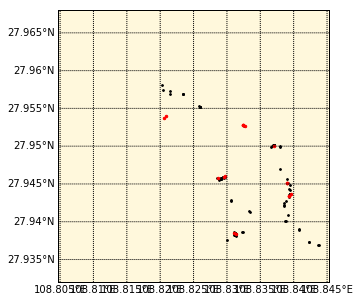

In [10]:
# set up the basemap
m = Basemap(width=4000,height=4000,
            resolution='c',projection='laea',\
            lat_0=27.95,lon_0=108.825)
fig = plt.figure(figsize=(5,5))
m.fillcontinents(color='cornsilk',lake_color='white',zorder=0)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(108,109,0.005),labels=[False,False,False,True])
m.drawparallels(np.arange(27,28,0.005),labels=[True,False,False,False])

# scatter the data
x, y = m(np.array(Luoman_bedding['longitude']), np.array(Luoman_bedding['latitude']))
m.scatter(x, y, 3, marker='o', color='k')

x, y = m(np.array(Luoman_notes['longitude']), np.array(Luoman_notes['latitude']))
m.scatter(x, y, 6, marker='o', color='r')

plt.show()

## Bedding Exploration

n           = 133
a95         = 2.00182809697
mean strike = 358.186154957
mean dip    = 11.7662092618


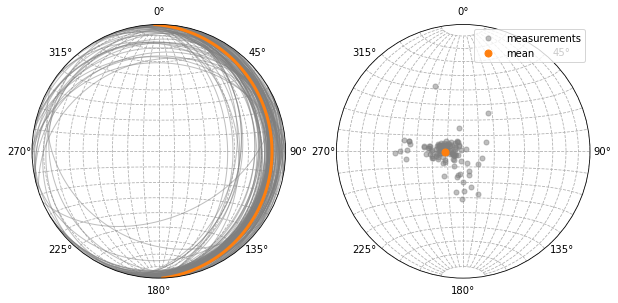

In [11]:
# convert strike/dip into pole trend-plunge
Luoman_bedding['dip_direction'] = (Luoman_bedding['strike'] + 90) % 360
Luoman_bedding['pole_trend'] = (Luoman_bedding['dip_direction'] + 180) % 360
Luoman_bedding['pole_plunge'] = 90 - Luoman_bedding['dip']

# calculate Fisher mean
di_block = make_di_block(Luoman_bedding['pole_trend'].tolist(), Luoman_bedding['pole_plunge'].tolist())
fpars = fisher_mean(di_block)

mean_dip_direction = (fpars['dec'] + 180) % 360
mean_strike = (mean_dip_direction - 90) % 360
mean_dip = 90 - fpars['inc']

print('n           = ' + str(len(Luoman_bedding.index)))
print('a95         = ' + str(fpars['alpha95']))
print('mean strike = ' + str(mean_strike))
print('mean dip    = ' + str(mean_dip))

# plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection':'stereonet'})

ax[0].plane(Luoman_bedding['strike'], Luoman_bedding['dip'], c='C7', linewidth=1, alpha=0.5)
ax[0].plane(mean_strike, mean_dip, c='C1', linewidth=3)
ax[0].grid(ls='--')

ax[1].pole(Luoman_bedding['strike'], Luoman_bedding['dip'], c='C7', markersize=5, alpha=0.5, label='measurements')
ax[1].pole(mean_strike,mean_dip, c='C1', markersize=7, label='mean')
ax[1].grid(ls='--')
ax[1].legend()

plt.show(fig)

In [12]:
# for interactivity, uncomment the below
#%matplotlib notebook

# to turn interactivity back off, re-comment above, and uncomment the below
#%matplotlib inline

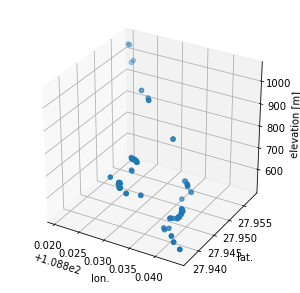

In [13]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection':'3d'})

ax.scatter(Luoman_bedding['longitude'], Luoman_bedding['latitude'], Luoman_bedding['elevation'])
ax.set_xlabel('lon.')
ax.set_ylabel('lat.')
ax.set_zlabel('elevation [m]')

plt.show(fig)

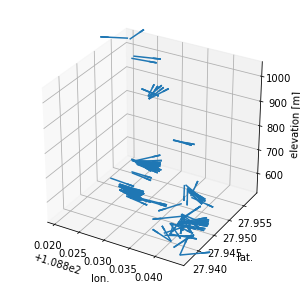

In [14]:
# convert dip direction-dip to Cartesian
Luoman_bedding['cart_y'] = np.cos(np.deg2rad(Luoman_bedding['dip_direction'])) * np.cos(np.deg2rad(Luoman_bedding['dip']))
Luoman_bedding['cart_x'] = np.sin(np.deg2rad(Luoman_bedding['dip_direction'])) * np.cos(np.deg2rad(Luoman_bedding['dip']))
Luoman_bedding['cart_z'] = np.sin(np.deg2rad(Luoman_bedding['dip']))

fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection':'3d'})

ax.quiver(Luoman_bedding['longitude'], Luoman_bedding['latitude'], Luoman_bedding['elevation'],
          Luoman_bedding['cart_x'], Luoman_bedding['cart_y'], -Luoman_bedding['cart_z'],
          length=0.005)
ax.set_xlabel('lon.')
ax.set_ylabel('lat.')
ax.set_zlabel('elevation [m]')

plt.show(fig)

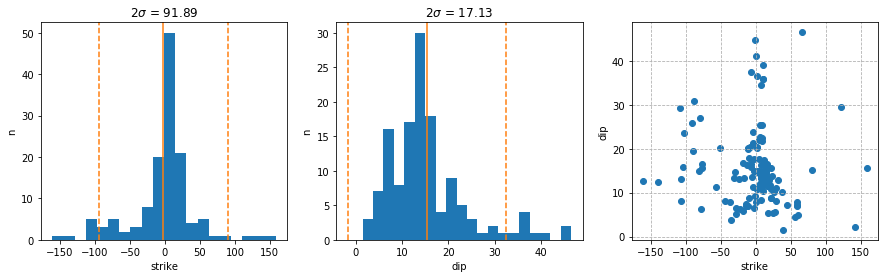

In [15]:
# for better visualization
for i in range(len(Luoman_bedding.index)):
    if Luoman_bedding['strike'][i] < 180:
        Luoman_bedding.loc[i,'plotting_strike'] = Luoman_bedding['strike'][i]
    else:
        Luoman_bedding.loc[i,'plotting_strike'] = Luoman_bedding['strike'][i]-360

stats.scoreatpercentile(Luoman_bedding['plotting_strike'], 2.5)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

ax[0].hist(Luoman_bedding['plotting_strike'], bins=20)
ax[0].axvline(np.mean(Luoman_bedding['plotting_strike']) - 2*np.std(Luoman_bedding['plotting_strike']), ls='--', c='C1')
ax[0].axvline(np.mean(Luoman_bedding['plotting_strike']) + 2*np.std(Luoman_bedding['plotting_strike']), ls='--', c='C1')
ax[0].axvline(np.mean(Luoman_bedding['plotting_strike']), c='C1')
ax[0].set_title('2$\sigma$ = ' + str(np.round(2*np.std(Luoman_bedding['plotting_strike']),2)))
ax[0].set_xlabel('strike')
ax[0].set_ylabel('n')

ax[1].hist(Luoman_bedding['dip'], bins=20)
ax[1].axvline(np.mean(Luoman_bedding['dip']) - 2*np.std(Luoman_bedding['dip']), ls='--', c='C1')
ax[1].axvline(np.mean(Luoman_bedding['dip']) + 2*np.std(Luoman_bedding['dip']), ls='--', c='C1')
ax[1].axvline(np.mean(Luoman_bedding['dip']), c='C1')
ax[1].set_title('2$\sigma$ = ' + str(np.round(2*np.std(Luoman_bedding['dip']),2)))
ax[1].set_xlabel('dip')
ax[1].set_ylabel('n')

ax[2].scatter(Luoman_bedding['plotting_strike'], Luoman_bedding['dip'])
ax[2].set_xlabel('strike')
ax[2].set_ylabel('dip')
ax[2].grid(ls='--')

plt.show(fig)

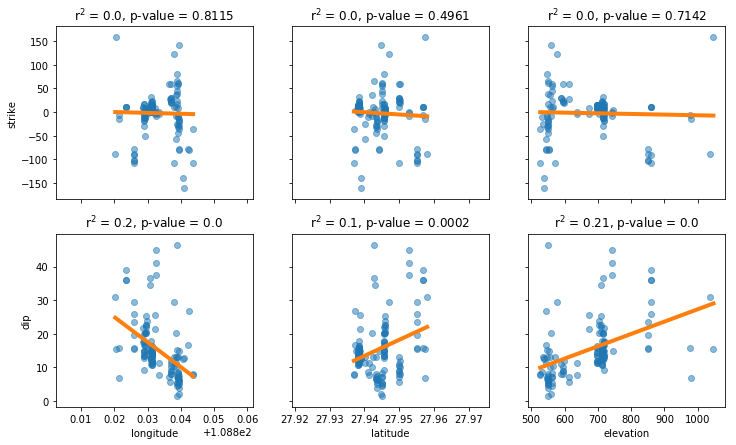

In [16]:
geog_vars = [Luoman_bedding['longitude'], Luoman_bedding['latitude'], Luoman_bedding['elevation']]
bedding_vars = [Luoman_bedding['plotting_strike'], Luoman_bedding['dip']]

fig, ax = plt.subplots(nrows=len(bedding_vars), ncols=len(geog_vars), figsize=(12,7), sharex='col', sharey='row')

for i in range(len(bedding_vars)):
    for j in range(len(geog_vars)):
        slope, intercept, r_value, p_value, std_err = stats.linregress(geog_vars[j], bedding_vars[i])
        fit_x = np.array([np.min(geog_vars[j]), np.max(geog_vars[j])])
        fit_y = fit_x * slope + intercept
        ax[i][j].scatter(geog_vars[j], bedding_vars[i], alpha=0.5)
        ax[i][j].plot(fit_x, fit_y, c='C1', lw=4)
        ax[i][j].set_title('r$^2$ = ' + str(np.round(r_value**2,2)) + ', p-value = ' + str(np.round(p_value,4)))

ax[0][0].set_ylabel('strike')

ax[1][0].set_ylabel('dip')
ax[1][0].set_xlabel('longitude')

ax[1][1].set_xlabel('latitude')

ax[1][2].set_xlabel('elevation')

plt.show(fig)

From these plots, we see that there is no correlation between strike and geographic location. However, there does appear to be a weak linear relationship between dip and longitude as well as dip and elevation. The correlation between dip and latitude is even weaker, and potentially negligible for our approximations.

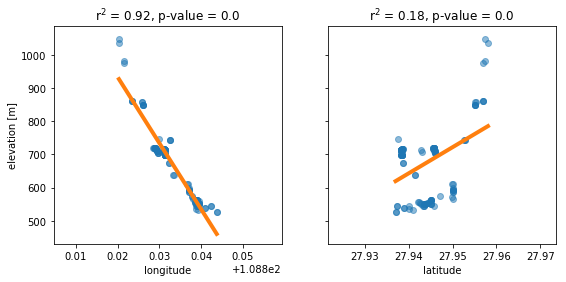

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(9,4))

slope, intercept, r_value, p_value, std_err = stats.linregress(Luoman_bedding['longitude'], Luoman_bedding['elevation'])
fit_x = np.array([np.min(Luoman_bedding['longitude']), np.max(Luoman_bedding['longitude'])])
fit_y = fit_x * slope + intercept
ax[0].scatter(Luoman_bedding['longitude'], Luoman_bedding['elevation'], alpha=0.5)
ax[0].plot(fit_x, fit_y, c='C1', lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('elevation [m]')
ax[0].set_title('r$^2$ = ' + str(np.round(r_value**2,2)) + ', p-value = ' + str(np.round(p_value,4)))

slope, intercept, r_value, p_value, std_err = stats.linregress(Luoman_bedding['latitude'], Luoman_bedding['elevation'])
fit_x = np.array([np.min(Luoman_bedding['latitude']), np.max(Luoman_bedding['latitude'])])
fit_y = fit_x * slope + intercept
ax[1].scatter(Luoman_bedding['latitude'], Luoman_bedding['elevation'], alpha=0.5)
ax[1].plot(fit_x, fit_y, c='C1', lw=4)
ax[1].set_xlabel('latitude')
ax[1].set_title('r$^2$ = ' + str(np.round(r_value**2,2)) + ', p-value = ' + str(np.round(p_value,4)))

plt.show(fig)

There is a strong correlation between elevation and longitude but only a weak one with latitude (i.e. the dip of the topography is essentially E).

## Calculations

### Linear Regression Dip

Based on the above, we can simplify our problem and:
* obtain the dip at a particular section based on elevation only
* ignore any small N-S variation in bedding
* obtain the distance between sections by projecting onto a single E-W transect
* assume strike = 0

In [18]:
# get the mean latitude of all the sections - this will be the latitude we will project onto for our calculations
mean_lat = np.mean(Luoman_notes['latitude'])

# get the min and max longitude and the min and max elevation for each section
n_sections = 7
min_lons = np.array([])
max_lons = np.array([])
min_elevs = np.array([])
max_elevs = np.array([])
for i in range(n_sections):
    lons = np.array([])
    elevs = np.array([])
    for j in range(len(Luoman_notes.index)):
        if ('Luoman ' + str(i+1)) in Luoman_notes['notes'][j]:
            lons = np.append(lons, Luoman_notes['longitude'][j])
            elevs = np.append(elevs, Luoman_notes['elevation'][j])
    min_lons = np.append(min_lons, np.min(lons))
    max_lons = np.append(max_lons, np.max(lons))
    min_elevs = np.append(min_elevs, np.min(elevs))
    max_elevs = np.append(max_elevs, np.max(elevs))
    
# get the distance (projected onto a E-W transect along the mean latitude) between Luoman 4 (the lowest/easternmost section)
# and the other sections 
x_4_1_a = vincenty_inverse((min_lons[3], mean_lat), (max_lons[0], mean_lat)) * 1000
x_4_2_a = vincenty_inverse((min_lons[3], mean_lat), (max_lons[1], mean_lat)) * 1000
x_4_3_a = vincenty_inverse((min_lons[3], mean_lat), (max_lons[2], mean_lat)) * 1000
x_4_5_a = vincenty_inverse((min_lons[3], mean_lat), (max_lons[4], mean_lat)) * 1000
x_4_6_a = vincenty_inverse((min_lons[3], mean_lat), (max_lons[5], mean_lat)) * 1000
x_4_7_a = vincenty_inverse((min_lons[3], mean_lat), (max_lons[6], mean_lat)) * 1000

# same as above, but for the case when the dip of the stratigraphy is greater than the dip of the topography
x_4_1_b = vincenty_inverse((max_lons[3], mean_lat), (min_lons[0], mean_lat)) * 1000
x_4_2_b = vincenty_inverse((max_lons[3], mean_lat), (min_lons[1], mean_lat)) * 1000
x_4_3_b = vincenty_inverse((max_lons[3], mean_lat), (min_lons[2], mean_lat)) * 1000
x_4_5_b = vincenty_inverse((max_lons[3], mean_lat), (min_lons[4], mean_lat)) * 1000
x_4_6_b = vincenty_inverse((max_lons[3], mean_lat), (min_lons[5], mean_lat)) * 1000
x_4_7_b = vincenty_inverse((max_lons[3], mean_lat), (min_lons[6], mean_lat)) * 1000

# get the elevation difference between Luoman 4 and the other sections
z_4_1_a = abs(min_elevs[0] - max_elevs[3])
z_4_2_a = abs(min_elevs[1] - max_elevs[3])
z_4_3_a = abs(min_elevs[2] - max_elevs[3])
z_4_5_a = abs(min_elevs[4] - max_elevs[3])
z_4_6_a = abs(min_elevs[5] - max_elevs[3])
z_4_7_a = abs(min_elevs[6] - max_elevs[3])

# same as above, but for the case when the dip of the stratigraphy is greater than the dip of the topography
z_4_1_b = abs(max_elevs[0] - min_elevs[3])
z_4_2_b = abs(max_elevs[1] - min_elevs[3])
z_4_3_b = abs(max_elevs[2] - min_elevs[3])
z_4_5_b = abs(max_elevs[4] - min_elevs[3])
z_4_6_b = abs(max_elevs[5] - min_elevs[3])
z_4_7_b = abs(max_elevs[6] - min_elevs[3])

# get the linear relationship between dip and elevation
slope, intercept, r_value, p_value, std_err = stats.linregress(Luoman_bedding['elevation'], Luoman_bedding['dip'])

# get the mean dip between Luoman 4 and the other sections based on that relationship
dip_4_1_a = slope * ((min_elevs[0] + max_elevs[3])/2) + intercept
dip_4_2_a = slope * ((min_elevs[1] + max_elevs[3])/2) + intercept
dip_4_3_a = slope * ((min_elevs[2] + max_elevs[3])/2) + intercept
dip_4_5_a = slope * ((min_elevs[4] + max_elevs[3])/2) + intercept
dip_4_6_a = slope * ((min_elevs[5] + max_elevs[3])/2) + intercept
dip_4_7_a = slope * ((min_elevs[6] + max_elevs[3])/2) + intercept

# same as above, but for the case when the dip of the stratigraphy is greater than the dip of the topography
dip_4_1_b = slope * ((max_elevs[0] + min_elevs[3])/2) + intercept
dip_4_2_b = slope * ((max_elevs[1] + min_elevs[3])/2) + intercept
dip_4_3_b = slope * ((max_elevs[2] + min_elevs[3])/2) + intercept
dip_4_5_b = slope * ((max_elevs[4] + min_elevs[3])/2) + intercept
dip_4_6_b = slope * ((max_elevs[5] + min_elevs[3])/2) + intercept
dip_4_7_b = slope * ((max_elevs[6] + min_elevs[3])/2) + intercept

# get the gradient (topographic dip) between Luoman 4 and the other sections
grad_4_1_a = np.rad2deg(np.tan(z_4_1_a/x_4_1_a))
grad_4_2_a = np.rad2deg(np.tan(z_4_2_a/x_4_2_a))
grad_4_3_a = np.rad2deg(np.tan(z_4_3_a/x_4_3_a))
grad_4_5_a = np.rad2deg(np.tan(z_4_5_a/x_4_5_a))
grad_4_6_a = np.rad2deg(np.tan(z_4_6_a/x_4_6_a))
grad_4_7_a = np.rad2deg(np.tan(z_4_7_a/x_4_7_a))

# same as above, but for the case when the dip of the stratigraphy is greater than the dip of the topography
grad_4_1_b = np.rad2deg(np.tan(z_4_1_b/x_4_1_b))
grad_4_2_b = np.rad2deg(np.tan(z_4_2_b/x_4_2_b))
grad_4_3_b = np.rad2deg(np.tan(z_4_3_b/x_4_3_b))
grad_4_5_b = np.rad2deg(np.tan(z_4_5_b/x_4_5_b))
grad_4_6_b = np.rad2deg(np.tan(z_4_6_b/x_4_6_b))
grad_4_7_b = np.rad2deg(np.tan(z_4_7_b/x_4_7_b))

Let's just see if there is a radical difference in slopes based on which case we are looking at:

In [19]:
print(str(dip_4_1_a) + ' and ' + str(dip_4_1_b))
print(str(dip_4_2_a) + ' and ' + str(dip_4_2_b))
print(str(dip_4_3_a) + ' and ' + str(dip_4_3_b))
print(str(dip_4_5_a) + ' and ' + str(dip_4_5_b))
print(str(dip_4_6_a) + ' and ' + str(dip_4_6_b))
print(str(dip_4_7_a) + ' and ' + str(dip_4_7_b))

13.4890447713 and 13.7463897279
19.2057791638 and 19.6101783813
13.7096261627 and 13.8015350757
10.7869227273 and 10.9339769882
11.5957211622 and 11.5038122491
14.169170728 and 14.2243160758


In [20]:
print(str(grad_4_1_a) + ' and ' + str(grad_4_1_b))
print(str(grad_4_2_a) + ' and ' + str(grad_4_2_b))
print(str(grad_4_3_a) + ' and ' + str(grad_4_3_b))
print(str(grad_4_5_a) + ' and ' + str(grad_4_5_b))
print(str(grad_4_6_a) + ' and ' + str(grad_4_6_b))
print(str(grad_4_7_a) + ' and ' + str(grad_4_7_b))

9.59055724231 and 10.4542914355
13.0680363588 and 13.5153124548
8.66313534285 and 8.20448685421
0.0 and 15.2584659422
10.5151322984 and 10.2281602209
14.6628440401 and 14.4028083456


No significant difference, except in case 4_5, where the two sections are very close to being at the same elevation anyway.

Now get the stratigraphic thicknesses between sections based on the following equations, where $\alpha$ is the dip and $t$ is the stratigraphic thickness.

If the topographic dip is larger than the stratgraphic dip, we are moving up section and:

$$
t_{1} = (z - x\tan\alpha)\cos\alpha
$$

Otherwise we are moving down section and:

$$
t_{2} = (x - \frac{z}{\tan\alpha})\sin\alpha
$$

In fact, $t_{1} = -t_{2}$, but since we use different variables in each case, we may as well use them separately.

In [21]:
if grad_4_1_a > dip_4_1_a:
    t_4_1_LR =  (z_4_1_a - x_4_1_a * np.tan(np.deg2rad(dip_4_1_a))) * np.cos(np.deg2rad(dip_4_1_a))
else:
    t_4_1_LR = -(x_4_1_b - z_4_1_b / np.tan(np.deg2rad(dip_4_1_b))) * np.sin(np.deg2rad(dip_4_1_b))
    
if grad_4_2_a > dip_4_2_a:
    t_4_2_LR =  (z_4_2_a - x_4_2_a * np.tan(np.deg2rad(dip_4_2_a))) * np.cos(np.deg2rad(dip_4_2_a))
else:
    t_4_2_LR = -(x_4_2_b - z_4_2_b / np.tan(np.deg2rad(dip_4_2_b))) * np.sin(np.deg2rad(dip_4_2_b))
    
if grad_4_3_a > dip_4_3_a:
    t_4_3_LR =  (z_4_3_a - x_4_3_a * np.tan(np.deg2rad(dip_4_3_a))) * np.cos(np.deg2rad(dip_4_3_a))
else:
    t_4_3_LR = -(x_4_3_b - z_4_3_b / np.tan(np.deg2rad(dip_4_3_b))) * np.sin(np.deg2rad(dip_4_3_b))
    
if grad_4_5_a > dip_4_5_a:
    t_4_5_LR =  (z_4_5_a - x_4_5_a * np.tan(np.deg2rad(dip_4_5_a))) * np.cos(np.deg2rad(dip_4_5_a))
else:
    t_4_5_LR = -(x_4_5_b - z_4_5_b / np.tan(np.deg2rad(dip_4_5_b))) * np.sin(np.deg2rad(dip_4_5_b))
    
if grad_4_6_a > dip_4_6_a:
    t_4_6_LR =  (z_4_6_a - x_4_6_a * np.tan(np.deg2rad(dip_4_6_a))) * np.cos(np.deg2rad(dip_4_6_a))
else:
    t_4_6_LR = -(x_4_6_b - z_4_6_b / np.tan(np.deg2rad(dip_4_6_b))) * np.sin(np.deg2rad(dip_4_6_b))
    
if grad_4_7_a > dip_4_7_a:
    t_4_7_LR =  (z_4_7_a - x_4_7_a * np.tan(np.deg2rad(dip_4_7_a))) * np.cos(np.deg2rad(dip_4_7_a))
else:
    t_4_7_LR = -(x_4_7_b - z_4_7_b / np.tan(np.deg2rad(dip_4_7_b))) * np.sin(np.deg2rad(dip_4_7_b))
    
print('t_4_1_LR = ' + str(np.round(t_4_1_LR,2)) + ' m')
print('t_4_2_LR = ' + str(np.round(t_4_2_LR,2)) + ' m')
print('t_4_3_LR = ' + str(np.round(t_4_3_LR,2)) + ' m')
print('t_4_5_LR = ' + str(np.round(t_4_5_LR,2)) + ' m')
print('t_4_6_LR = ' + str(np.round(t_4_6_LR,2)) + ' m')
print('t_4_7_LR = ' + str(np.round(t_4_7_LR,2)) + ' m')

t_4_1_LR = -59.05 m
t_4_2_LR = -248.34 m
t_4_3_LR = -122.87 m
t_4_5_LR = 4.56 m
t_4_6_LR = -7.3 m
t_4_7_LR = -1.37 m


### Mean Dip

Redo the calculations, except assume a consistent dip panel for the entire hillside.

In [22]:
mean_dip = np.mean(Luoman_bedding['dip'])

if grad_4_1_a > mean_dip:
    t_4_1_mean =  (z_4_1_a - x_4_1_a * np.tan(np.deg2rad(mean_dip))) * np.cos(np.deg2rad(mean_dip))
else:
    t_4_1_mean = -(x_4_1_b - z_4_1_b / np.tan(np.deg2rad(mean_dip))) * np.sin(np.deg2rad(mean_dip))
    
if grad_4_2_a > mean_dip:
    t_4_2_mean =  (z_4_2_a - x_4_2_a * np.tan(np.deg2rad(mean_dip))) * np.cos(np.deg2rad(mean_dip))
else:
    t_4_2_mean = -(x_4_2_b - z_4_2_b / np.tan(np.deg2rad(mean_dip))) * np.sin(np.deg2rad(mean_dip))
    
if grad_4_3_a > mean_dip:
    t_4_3_mean =  (z_4_3_a - x_4_3_a * np.tan(np.deg2rad(mean_dip))) * np.cos(np.deg2rad(mean_dip))
else:
    t_4_3_mean = -(x_4_3_b - z_4_3_b / np.tan(np.deg2rad(mean_dip))) * np.sin(np.deg2rad(mean_dip))
    
if grad_4_5_a > mean_dip:
    t_4_5_mean =  (z_4_5_a - x_4_5_a * np.tan(np.deg2rad(mean_dip))) * np.cos(np.deg2rad(mean_dip))
else:
    t_4_5_mean = -(x_4_5_b - z_4_5_b / np.tan(np.deg2rad(mean_dip))) * np.sin(np.deg2rad(mean_dip))
    
if grad_4_6_a > mean_dip:
    t_4_6_mean =  (z_4_6_a - x_4_6_a * np.tan(np.deg2rad(mean_dip))) * np.cos(np.deg2rad(mean_dip))
else:
    t_4_6_mean = -(x_4_6_b - z_4_6_b / np.tan(np.deg2rad(mean_dip))) * np.sin(np.deg2rad(mean_dip))
    
if grad_4_7_a > mean_dip:
    t_4_7_mean =  (z_4_7_a - x_4_7_a * np.tan(np.deg2rad(mean_dip))) * np.cos(np.deg2rad(mean_dip))
else:
    t_4_7_mean = -(x_4_7_b - z_4_7_b / np.tan(np.deg2rad(mean_dip))) * np.sin(np.deg2rad(mean_dip))
    
print('t_4_1_mean = ' + str(np.round(t_4_1_mean,2)) + ' m')
print('t_4_2_mean = ' + str(np.round(t_4_2_mean,2)) + ' m')
print('t_4_3_mean = ' + str(np.round(t_4_3_mean,2)) + ' m')
print('t_4_5_mean = ' + str(np.round(t_4_5_mean,2)) + ' m')
print('t_4_6_mean = ' + str(np.round(t_4_6_mean,2)) + ' m')
print('t_4_7_mean = ' + str(np.round(t_4_7_mean,2)) + ' m')

t_4_1_mean = -86.78 m
t_4_2_mean = -89.37 m
t_4_3_mean = -157.16 m
t_4_5_mean = -1.01 m
t_4_6_mean = -26.43 m
t_4_7_mean = -22.52 m


### Compare Methods

In [23]:
print(str(t_4_1_LR) + ' and ' + str(t_4_1_mean))
print(str(t_4_2_LR) + ' and ' + str(t_4_2_mean))
print(str(t_4_3_LR) + ' and ' + str(t_4_3_mean))
print(str(t_4_5_LR) + ' and ' + str(t_4_5_mean))
print(str(t_4_6_LR) + ' and ' + str(t_4_6_mean))
print(str(t_4_7_LR) + ' and ' + str(t_4_7_mean))

-59.0454347986 and -86.780728302
-248.335949916 and -89.3734746346
-122.873593645 and -157.161248098
4.55531375004 and -1.01402037254
-7.30270356718 and -26.4271567612
-1.37332223889 and -22.5223390841


They produce significantly different results - but on the whole, both methods calculate that going up elevation ends up placing us lower in the stratigraphy.